# OCR Practice

## 1. Overall structure of OCR
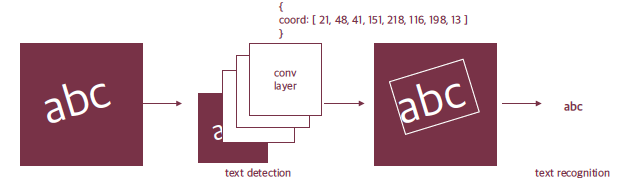

* 이미지 속에서 영문을 Bounding box로 찾아내고 그 안에 어떤 Text가 포함되는지 알 수 있는 시스템이다.
* Text Detection은 Segmentation 기반의 CRAFT를 활용한 keras-ocr을 활용한다.
* Recognition 모델은 keras-ocr을 사용하지 않고 직접 만든다.
  * keras-ocr에서도 Convolution layer와 RNN을 결합하고 CTC로 학습된 CRNN이 사용되었다.


## 2. Dataset for OCR
* OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야하는 번거로움이 있어 컴퓨터로 대량 문자 이미지 데이터를 만드는 방법을 사용해 학습을 시킨다.
* 원하는 언어를 원하는 폰트와 원하는 배치 및 크기로 문자 이미지를 대량으로 만들어 낼 수 있다.

[Dataset : Dropbox-data_lmdb_release](https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0)

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## 3. Recognition Model (1) CRNN
[CRNN 논문 : An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)
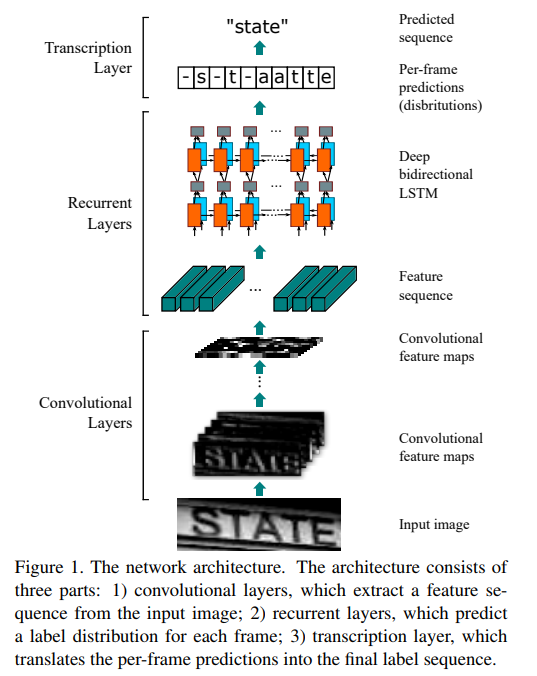
* CRNN의 구조는 위 그림에서 아래부터 올라가는 순서로 본다.
* 입력 이미지를 Convolution Layer를 통해 Feature를 추출한다.
* Recurrent Layer는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응이 가능하다.
* Transcriptioin layer(Fully-connected layer)는 step마다 어떤 character의 확률이 높은지 예측한다.
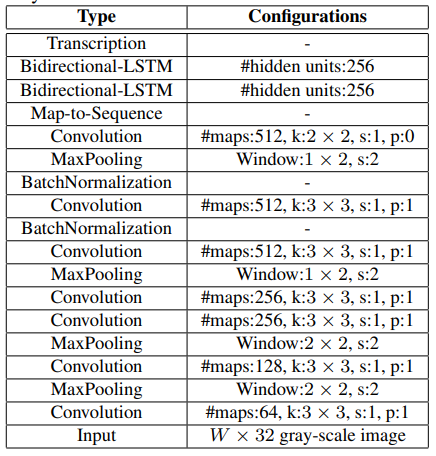

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


### (1) lmbd
* LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자이다.

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


## 4. Recognition model (2) Input Image
* 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인한다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


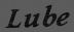

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


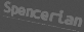

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


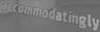

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


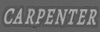

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

## 5. Recognition model (3) Encode
* Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있지만 이는 학습을 위해서는 적절한 형태가 아니다.
* 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 한다.
* LabelConverter 클래스 작성
  * \__init\__()에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장한다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어진다.
  * 공백(blank) 문자를 지정한다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용한다.
  * decode()는 각 index를 다시 character로 변환 후 이어주어 우리가 읽을 수 있는 text로 바꾸어준다.

In [6]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## 6. Recognition model (4) Build CRNN model
* 입출력을 준비했으니 모델을 만들어 본다. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만든다.

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### (1) Keras - K.ctc_batch_cost()
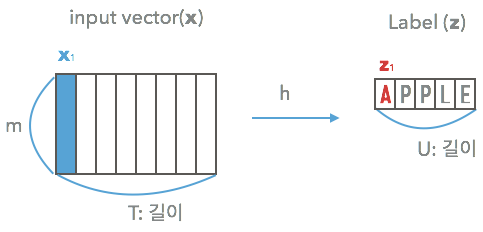
* CTC Loss를 활용해야 하는 모델은 위 그림과 같은 상황을 다루기 위함이다.
* 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE처럼 나올 수 있다.
* K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  * y_true : 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정.
  * y_pred : 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
  * input_length tensor : 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74.
  * label_length tensor : 라벨의 실제 정답 길이 U로서 이 경우에는 4.
  * samples는 배치사이즈를 의미한다.

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## 7. Recognition model(5) Train & Inference
* 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습시킨다.

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [11]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - 172s 261ms/step - loss: 27.5419 - val_loss: 22.9437

Epoch 00001: val_loss improved from inf to 22.94365, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 144s 255ms/step - loss: 18.9582 - val_loss: 9.4479

Epoch 00002: val_loss improved from 22.94365 to 9.44794, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 144s 256ms/step - loss: 8.0233 - val_loss: 6.6408

Epoch 00003: val_loss improved from 9.44794 to 6.64080, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 145s 256ms/step - loss: 5.5127 - val_loss: 5.4418

Epoch 00004: val_loss improved from 6.64080 to 5.44181, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 145s 256ms/step - loss: 4.2287 - val_loss: 4.8766

Epoch 00005: val_loss 

In [13]:
# 데이터셋과 모델을 불러온다.
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size = BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없다.
# 그래서 crnn 모델의 입력 중 'input_image' 부분만 사용한 모델을 새로 만든다.
# inference 전용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


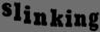

Result: 	 ALEPPO99999999999999999


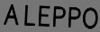

Result: 	 FWENDE999999999999999999


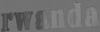

Result: 	 NATHANS99999999999999999


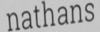

Result: 	 HALLO999999999999999999


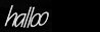

Result: 	 HURTS9999999999999999999


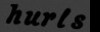

Result: 	 DOWNSIZE9999999999999999


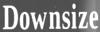

Result: 	 ROBOTIC99999999999999999


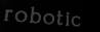

Result: 	 SLOPPY99999999999999999


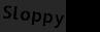

Result: 	 HERMITE99999999999999999


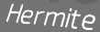

In [14]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 한다.
# 코드 하나하나를 이해하기는 조금 어려울 수 있다.
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy = False, beam_width=5, top_paths = 1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행한다.
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해준다.
def check_inference(model, dataset, index=5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars='-'+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))
        
check_inference(model_pred, test_set, index=10)

In [28]:
import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = os.path.join(HOME_DIR+'/data/', 'sample.jpg')

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


## Project : End-to-End OCR

In [29]:
def detect_text(img_path):
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs

In [30]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

array([[[209, 214, 213],
        [206, 211, 210],
        [202, 207, 206],
        ...,
        [178, 182, 187],
        [178, 182, 187],
        [181, 185, 190]],

       [[184, 189, 188],
        [183, 188, 187],
        [181, 186, 185],
        ...,
        [178, 182, 187],
        [177, 181, 186],
        [178, 182, 187]],

       [[171, 176, 175],
        [171, 176, 175],
        [172, 177, 176],
        ...,
        [179, 183, 188],
        [180, 184, 189],
        [183, 187, 192]],

       ...,

       [[103,  77,  60],
        [105,  79,  62],
        [106,  80,  63],
        ...,
        [101,  73,  56],
        [102,  74,  57],
        [102,  74,  57]],

       [[104,  78,  61],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [103,  75,  58]],

       [[103,  77,  60],
        [105,  79,  62],
        [107,  81,  64],
        ...,
        [102,  74,  57],
        [103,  75,  58],
        [104,  76,  59]]

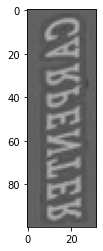

In [31]:
plt.imshow(img[:,:,::-1])

In [32]:
#잘려진 단어 이미지를 인식하는 코드
def recognize_img(input_img, input_img_size=(100,32)):
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

Result: 	 YRGI9999999999999999999


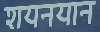

Result: 	 SLEEPER9999999999999999


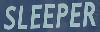

In [33]:
for _img in cropped_img:
    recognize_img(_img)